## 1. Defining Useful Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d as gauss

In [2]:
# Normalize the wavefunction
def normalize_wavefunction(psi):
    """Normalize a wavefunction array"""
    norm = np.sqrt(np.sum(np.abs(psi) ** 2) * dx) 
    return psi / norm

In [3]:
# Normalize the density (wavefunction squared)
def normalize_density(rho):
    """Normalize a density array"""
    norm = np.sum(np.abs(rho)) * dx
    return rho / norm

In [4]:
# Defining functions for initial guesses/external potentials
def gaussian(x,a,o,p):
    """Gaussian function of x"""
    f = a*(np.exp(-((x-p)**2)/(2*(o**2))))
    return f

def lorentzian(x, A, Gamma, b):
    """Lorentzian function of x"""
    l = A / (1 + ((x - b) / Gamma)**2)
    return l

In [5]:
# Defining higher order difference schemes for derivatives/integrals (np.gradient didn't work for me)
def derivative(arr, x):
    """Compute the first derivative using a 4th-order central finite difference method.""" 
    dx = np.diff(x)[0] # Assuming uniform grid spacing
    n = len(arr) 
    der = np.zeros(n) # 4th order central finite difference for interior points 
    for i in range(2, n-2):
         der[i] = (arr[i-2] - 8 * arr[i-1] + 8 * arr[i+1] - arr[i+2]) / (12 * dx) 
         
    # Lower-order scheme for the boundaries
    der[0] = (arr[1] - arr[0]) / dx # Forward difference
    der[1] = (arr[2] - arr[0]) / (2 * dx) 
    der[-1] = (arr[-1] - arr[-2]) / dx # Backward difference 
    der[-2] = (arr[-1] - arr[-3]) / (2 * dx)
    return der

def integral(f, x):
    """Compute integral using Boole's Rule (5th order difference method)."""
    #if len(x) < 5 or len(f) < 5:
    #    raise ValueError("Boole's rule requires at least 5 points")
    
    n = len(x)
    integral = 0.0
    for i in range(0, n-4, 4):
        h = x[i+1] - x[i]  # Step size (assume uniform spacing)
        integral += (2 * h / 45) * (7 * f[i] + 32 * f[i+1] + 12 * f[i+2] + 32 * f[i+3] + 7 * f[i+4])
    
    return integral

## 2. Choose the Potential

In [6]:
# First define the number of discrete steps in the well
s = 1001
sigma = 1/s
x = np.linspace(0, 1, s-1)
dx = x[1] - x[0]
well_size = 1

###############################################################################################################################
# Choose potential here

potential = gaussian(x,-1000,0.06,well_size/2)               # Single gaussian   (converges on SE perfectly)
#potential = gaussian(x,1000,0.06,well_size/2)                # Positive amplitude gaussian   (starts off well but diverges)
#potential = -np.sin(np.pi*x)                                 # -sin(x)                       (doesn't get as far as previous)
#potential = lorentzian(x, -1000, 0.06, 0.5)                  # negative amplitude lorentzian (slow, but diverges pretty much right on solution)
#potential = lorentzian(x, -100, 0.06, 0.5)                   # negative amplitude lorentzian (displays weird wobbling behaviour)
#potential = ((x-0.5)**2)*100                                 # harmonic oscillator           (diverges about half way there) 

#potential = gaussian(x,-1000,0.06,0.4) + gaussian(x,-1000,0.06,0.6)                                   # double gaussian      (diverges pretty close to right answer)

###############################################################################################################################

## 3. Choose the Initial Guess Density

In [7]:
step = 1000
x = np.linspace(0, 1, step)
dx = x[1] - x[0]

###############################################################################################################################
# Choose initial guess for density here

density_initial = (normalize_wavefunction( gaussian(x, 8, 0.08, 0.5) ))**2 
#density_initial = (normalize_wavefunction( gaussian(x, 8, 0.08, 0.4) + gaussian(x, 8, 0.08, 0.6)))**2

psi_initial = np.sqrt(density_initial)
###############################################################################################################################

## 4. Solving the Schroedinger Equation as a Benchmark for the Minimization Algorithm

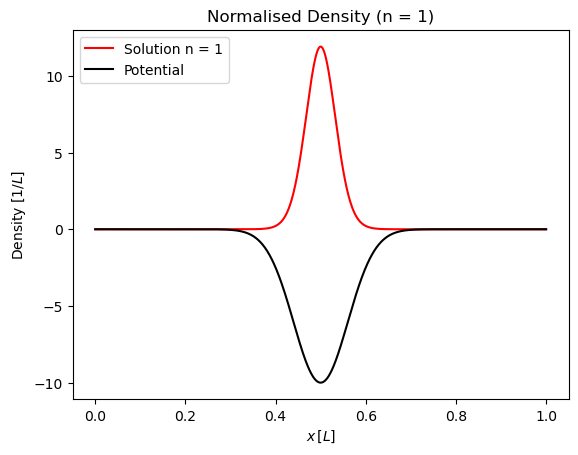

First 3 energy levels: [-762.28337375 -347.30221432  -71.00373559]


In [8]:
##### Creating the Kinetic energy matrix #####

up = np.ones(s-2)                 # Vector of ones (-2 due to boundary conditions)
T_up = np.diag(up, 1)             # Placing the ones one above the diagonal entries    
T_down = T_up.T                   # Getting the transpose to place ones below diagonal entries
T_diag = 2*np.eye(s-1)            # Multiplying identity matrix by 2 to get twos in the diagonals
T_basic = T_up + T_down - T_diag  # Adding the three matrices together
T = -(1/(2*sigma**2)) * T_basic


##### Creating the Potential energy matrix #####

V = np.diag(potential)


##### Creating Hamiltonian Matrix (sum of kinetic and potential matrices) #####
H_new = T + V

# The eigenvalues of the Hamiltonian will be the energy and the eigenvectors will be the solution to the SE
# Finding the eigenvalues and eigenvectors
[E_new, psi_new] = np.linalg.eig(H_new)     # This function calculates the eigenvalues and eigenvectors using matrix diagnalization
inds = E_new.argsort()
E_new, psi_new = E_new[inds], psi_new[:,inds] # Sorting the eigenvalues and vectors together

dx = x[1] - x[0]

# Creating a list of the first 10 normalised wavefunctions
n = np.linspace(0,10,11)
psi_list = []
for i in n:
    psi_norm = normalize_wavefunction(psi_new[:,int(i)])
    psi_list.append(psi_norm)
    

# Uncomment to plot higher energy states
plt.figure(1)
plt.title("Normalised Density (n = 1)")
plt.plot(x,psi_list[0]**2,color='red',label='Solution n = 1')
#plt.plot(x,psi_list[1]**2,color='blue',label='Solution n = 2')
#plt.plot(x,psi_list[2]**2,color='green',label='Solution n = 3')
#plt.plot(x,psi_list[3]**2,color='orange',label='Solution n = 4')
plt.plot(x,potential/100,color='black', label='Potential')
plt.xlabel(r"$x \, [L]$")
plt.ylabel(r"Density $[1/L]$")
plt.legend(loc=2)
plt.show()
# Printing the first few energy levels
print("First 3 energy levels:", E_new[:3])

The Euler-Lagrange equation to solve is given by:
$$
\frac{\delta E[\rho]}{\delta \rho} = -\frac{1}{4}\frac{\nabla^2 \rho}{\rho} + \frac{1}{8} \frac{|\nabla \rho|^2}{\rho^2}+ V_{ext} = \mu
$$

## 5. Defining Functions used in Minimization Algorithm

In [9]:
def von_weiz(rho):
    """Von Weizsacker kinetic energy functional of density"""
    gradient = derivative(rho, x)
    integrator = ((np.abs(gradient))**2) / (8 * rho)
    functional = integral(integrator, x)
    
    
    return functional

In [10]:
# Computing the Lagrangian (used in checking if the Wolfe conditions are satisfied)
def lagrangian(psi, mu):
    """Compute the value of the Lagrangian given wavefunction and chemical potential """
    rho = psi**2
    
    vW_functional = integral(((np.abs(derivative(rho,x)))**2) / (8 * rho),x)
    
    energy = vW_functional + integral((potential * rho), x)
    
    constraint = mu*(np.sum(rho*dx) - 1)
    
    return energy - constraint

In [11]:
# Computing the functional derivative of the energy
def psi_functional_derivative(psi,potential):
    """Energy functional derivative output"""
    
    rho = psi**2
    first_derivative = derivative(rho, x)
    second_derivative = derivative(first_derivative, x)

    dEdp = -(1/4)*(second_derivative/rho) + (1/8)*( ((first_derivative)*(first_derivative))/(rho**2) ) + potential
    
    #dEdp = -(1/2)*(derivative(derivative(psi,x),x))/psi + potential
    
    dEdpsi = 2*psi*dEdp
    
    return dEdpsi

In [12]:
# Computing step direction 
def euler_lagrange(psi , mu):
    """Euler-Lagrange Equation output (step direction) in the reformulation"""
    
    dE = psi_functional_derivative(psi,potential)
    
    dL = dE - (2*psi*mu)
    
    return dL

In [13]:
# Convergence condition for terminating loop
def convergence_condition(psi):
    """Convergence Condition for loop (terminates when output is zero)"""
    
    dE = psi_functional_derivative(psi, potential)
    
    mu = mu_guess(psi)
    
    return dE - 2*psi*mu

In [14]:
# Computes chemical potential estimate
def mu_guess(psi):
    """Computes chemical potential estimate"""
    
    dEdpsi = psi_functional_derivative(psi, potential)
    
    integral = np.sum(dEdpsi * psi * dx)
    
    mu = (1/2) * integral
    
    return mu

In [15]:
# Orthogonalization scheme direction (projecting onto constrained space)
def psi_perp(psi, search_direction):
    """ Computes part of search direction orthogonal to psi""" 
    
    psi_perp_unnormalised = search_direction - psi*( (np.dot(psi,search_direction))/(np.dot(psi,psi)) )

    psi_perp = psi_perp_unnormalised/(np.linalg.norm(psi_perp_unnormalised))
                                                    
    return psi_perp

## 6. Minimization Algorithm Implementation

Wolfe condition satisfied


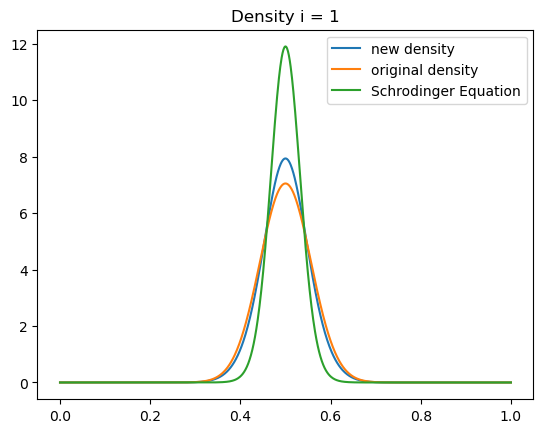

Tao = 364.36245122288494
Tau = 2000
theta = 1.0753535353535353
i = 1
Wolfe condition satisfied


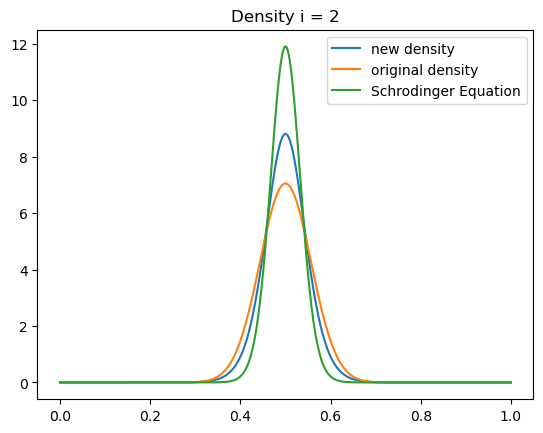

Tao = 293.69475037544015
Tau = 0.05652284156330729
theta = 1.061010101010101
i = 2
Wolfe condition satisfied


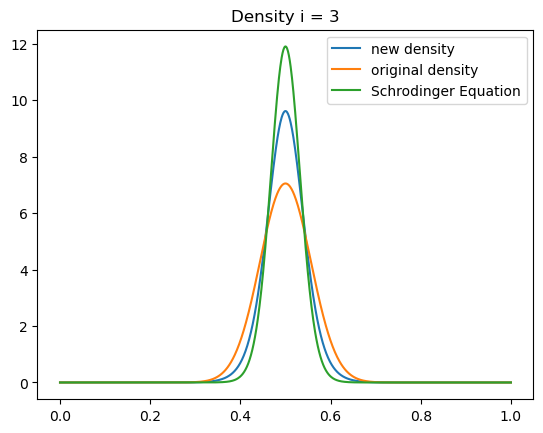

Tao = 224.45856877579803
Tau = 0.052908782917259777
theta = 1.0323232323232323
i = 3
Wolfe condition satisfied


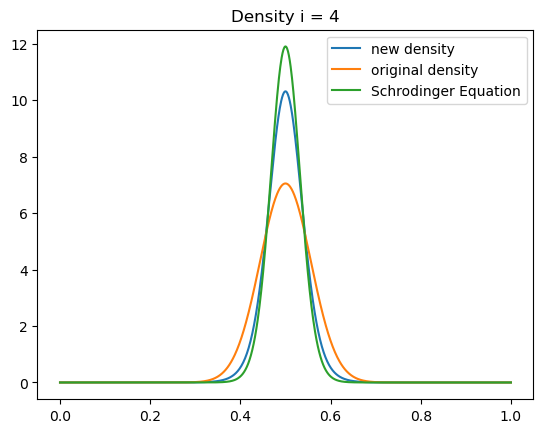

Tao = 161.575643994641
Tau = 0.046622634565947466
theta = 0.9749494949494949
i = 4
Wolfe condition satisfied


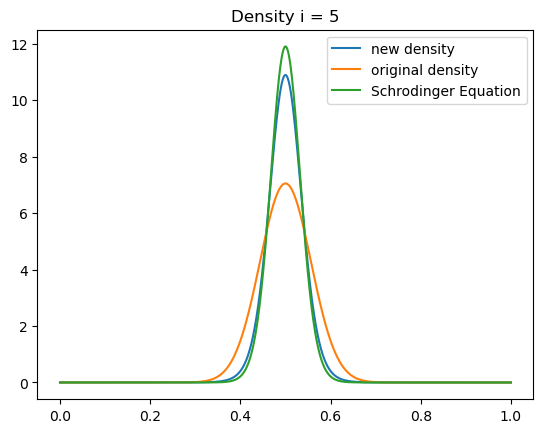

Tao = 106.51102663409385
Tau = 0.040111170396897794
theta = 0.9032323232323232
i = 5
Wolfe condition satisfied


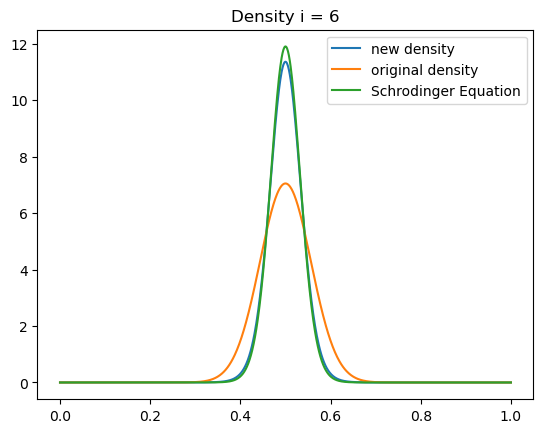

Tao = 59.84962579781026
Tau = 0.033701479814973366
theta = 0.8171717171717171
i = 6
Wolfe condition satisfied


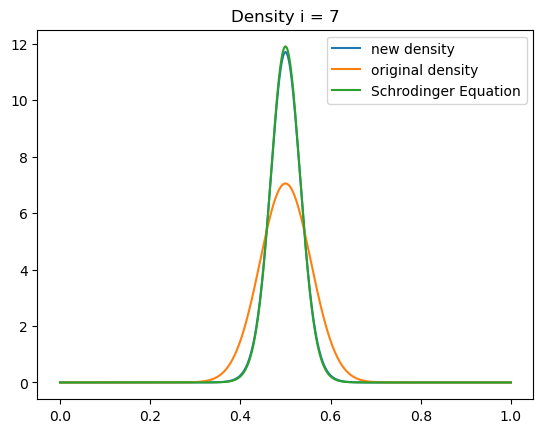

Tao = 23.775056003014484
Tau = 0.026003961762870773
theta = 0.688080808080808
i = 7
Wolfe condition satisfied


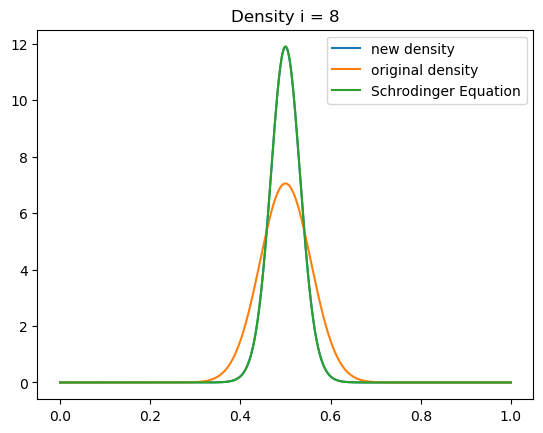

Tao = 4.024700906032673
Tau = 0.015057851231209736
theta = 0.4442424242424242
i = 8


<Figure size 640x480 with 0 Axes>

In [16]:
# For plotting the schrodinger equation results on the same graph for comparison
x_psi_list = np.linspace(0, 1, len(psi_list[0]))
interp_func = interp1d(x_psi_list, psi_list[0]**2, kind='linear')

og_psi = np.sqrt(density_initial)

# tao and tau measure how close the algorithm is to converging on the solution
tao = 2000  # Convergence condition
tau = 2000  # Terminates loop if there's not enough change each iteration
i=1


# start of the conjugate gradient method
g_old = euler_lagrange(psi_initial, mu_guess(psi_initial))

h_old = g_old


# Successful minimization whenever |tao| < 100
while np.abs(tao) > 10: #and tau > 0.001:
    
    Psi = psi_initial
    
    # Determining the chemical potential guess for this psi
    mu = mu_guess(Psi)
    
    # g is the functional derivative of the Lagrangian and points opposite the ground-state
    g = euler_lagrange(Psi,mu)
    g = gauss(g, 5)
    
    # Implementing the Polak–Ribière method
    h = -g + (np.dot(g-g_old,g))/(np.dot(g_old,g_old))*h_old
    

    ### Perform a line search for the optimal step size
    
    # Starting theta for conjugate gradient method
    theta_start = np.linalg.norm(psi_perp(Psi,h))/np.linalg.norm(Psi+h)
    
    
    thetas = np.linspace(0.1, 1.52, 100)
    
    min_energy = float('inf')
    theta_found = False 
    best_theta = theta_start
    
    
    for theta in thetas:
        
        psi_test = psi_perp(Psi,h)*np.sin(theta) + Psi*np.cos(theta)
        
        L_old = lagrangian(Psi,mu)
        L_new = lagrangian(psi_test,mu)
        
        h_old_step = h
        h_new_step = euler_lagrange(psi_test,mu)
        
        c_1 = 0.0001
        c_2 = 0.1
        
        q = (psi_test - Psi) / theta
        
        
        # Wolfe conditions
        if L_new <= L_old + np.dot(c_1*theta*h_old_step,q) and np.dot(h_new_step,q) >= np.dot(c_2*h_old_step,q): #and np.max(np.abs(g)) < 10000:
            theta_found = True
            print('Wolfe condition satisfied')
            break
        
        
        if not theta_found:
            theta = theta_start
    
    
    psi_new_unnorm = psi_perp(Psi,-g)*np.sin(theta) + Psi*np.cos(theta)
    
    
    # Renormalize new Psi
    Psi_new = normalize_wavefunction(np.abs(psi_new_unnorm))
    #Psi_new = psi_new_unnorm
    
    # Uncomment to see what g and h look like
    #plt.plot(x, g, 'r.',label='g')
    #plt.plot(x, h, 'b.',label='h')
    #plt.title(f"Energy Functional Derivative i = {i}")
    #plt.xlabel('x')
    #plt.ylabel(r'$\frac{dE}{d \psi}$')
    #plt.legend()
    #plt.show()
    

    plt.plot(x,Psi_new**2,label='new density')
    plt.plot(x,og_psi**2,label='original density')
    plt.plot(x,interp_func(x),label='Schrodinger Equation')
    plt.title(f'Density i = {i}')
    plt.legend()
    plt.show()
    
    
    # Updating convergence condition
    #old tao = np.sqrt(integral(convergence_condition(gauss(Psi_new[100:-100],5))**2,x[100:-100]))
    tao = np.sqrt(integral(convergence_condition(Psi_new)**2,x))
    
    if i == 1:
        tau = 2000
    else:
        tau = np.sqrt(integral( (Psi_new-psi_initial)**2 ,x))

    print(f"Tao = {tao}")
    print(f"Tau = {tau}")
    #print(f"Normalization = {np.nansum(np.abs(Psi_new**2)) *dx}")
    print(f"theta = {theta}")
    print(f"i = {i}")

    # Convergence conditions incase the functional derivative diverges
    if np.max(np.abs(g)) > 6*np.std(g):
        Psi_new = Psi
        print("The functional derivative diverged")
        break
        
    if np.any(Psi_new[:100] > 2) or np.any(Psi_new[-100:] > 2):
        Psi_new = Psi
        print("The functional derivative diverged at boundaries")
        break
    
    if i >=4:
        if np.any(Psi_new[:100] > 1) or np.any(Psi_new[-100:] > 1):
            Psi_new = Psi
            print("The functional derivative diverged at boundaries")
            break
            
    # Update density for the next iteration
    psi_initial = Psi_new
    
    g = g_old
    h = h_old
    
    i = i+1

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

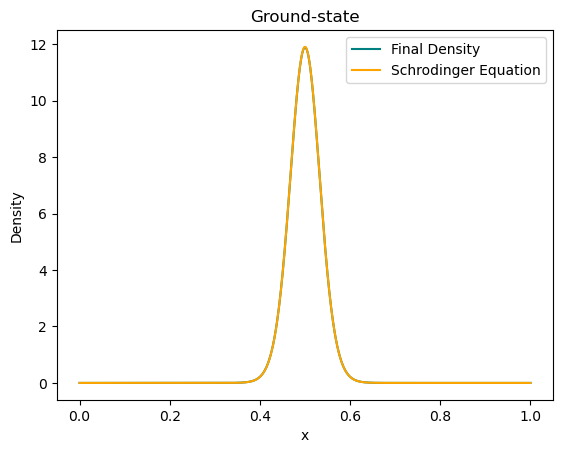

In [17]:
x_psi_list = np.linspace(0, 1, len(psi_list[0]))
interp_func = interp1d(x_psi_list, psi_list[0]**2, kind='linear')

plt.plot(x, Psi_new**2, label='Final Density', color = '#008080')
plt.plot(x, interp_func(x), label='Schrodinger Equation', color = '#FFA500')
plt.title('Ground-state')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show()

## 7. Calculating the energy corresponding to the computed density
$$
E[\rho] = \int \frac{\mid \nabla \rho(x) \mid^2}{8\rho(x)} dx + \int V_{ext}(x) \rho dx
$$

In [18]:
density = Psi_new**2

kinetic_energy = von_weiz(density)
integral_term = integral((potential * density), x)
energy = kinetic_energy + integral_term

density_quantum = psi_list[0]**2

kinetic_energy_quantum = von_weiz(density_quantum)
integral_term_quantum = integral((potential * density_quantum), x)
energy_quantum = kinetic_energy_quantum + integral_term_quantum

print('DFT Minimization Energy:', energy)
print('Eigenvalue Quantum energy:', E_new[0])
print('Schrodinger Equation Density:', energy_quantum)
#print('Difference between quantum and DFT:', E_new[0] - energy)

DFT Minimization Energy: -762.6963238105977
Eigenvalue Quantum energy: -762.2833737519541
Schrodinger Equation Density: -762.6991785822951
